In [1]:
import os
import csv
import numpy as np
import rasterio as rio
from scipy import misc
from matplotlib import pyplot as plt

In [2]:
from modis_utils.misc import restore_data, cache_data, normalize_data
from modis_utils.misc import get_data_paths, get_target_paths, get_data_from_data_file, get_target_from_target_file
from modis_utils.image_processing import get_pixel_weights, mask_lake_img

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
data_dir = '../simple_63/preprocessed_data/ALL/0/NDVI/change_fill_value'
n_data_per_year = 46

In [4]:
year_range = (2002, 2017)
train_year_range = (2002, 2014)
val_year_range = (2015, 2015)
test_year_range = (2016, 2017)

In [5]:
def find_mean_std(data_dir, year_range):
    list_imgs = []
    for year in range(year_range[0], year_range[1] + 1):
        year_data_dir = os.path.join(data_dir, str(year))
        for day in os.listdir(year_data_dir):
            img_path = os.path.join(year_data_dir, day, 'change_fill_value.dat')
            img = restore_data(img_path)
            list_imgs.append(img)
    list_imgs = np.vstack(list_imgs)
    return list_imgs.mean(), list_imgs.std()

In [6]:
mean_std_file_path = 'mean_std.dat'
if not os.path.isfile(mean_std_file_path):
    mean, std = find_mean_std(data_dir, train_year_range)
    print(mean, std)
    cache_data({'mean': mean, 'std': std}, 'mean_std.dat')
else:
    mean_std = restore_data(mean_std_file_path)
    mean = mean_std['mean']
    std = mean_std['std']
    print(mean, std)

4147.625748165997 3251.4123917274546


In [7]:
water_threshold = (1000 - mean)/std
water_threshold

-0.9680795202031212

In [8]:
preprocess_data_dir = 'preprocessed_data'
pixel_weights_dir = 'pixel_weights'
if not os.path.exists(preprocess_data_dir):
    os.makedirs(preprocess_data_dir)
    
if not os.path.exists(pixel_weights_dir):
    os.makedirs(pixel_weights_dir)

re_run = False
if re_run:
    for year in range(year_range[0], year_range[1] + 1):
        year_data_dir = os.path.join(data_dir, str(year))
        for day in os.listdir(year_data_dir):
            img_path = os.path.join(year_data_dir, day, 'change_fill_value.dat')
            img = restore_data(img_path)
            normalized_img = normalize_data(img, mean, std)
            normalized_img_path = os.path.join(preprocess_data_dir, '{}{}.dat'.format(year, day[-3:]))
            cache_data(normalized_img, normalized_img_path)
            
for path in os.listdir(preprocess_data_dir):
    normalized_img_path = os.path.join(preprocess_data_dir, path)
    img = restore_data(normalized_img_path)
    pixel_weight = get_pixel_weights(img, water_threshold)
    pixel_weight_path = os.path.join(pixel_weights_dir, path)
    cache_data(pixel_weight, pixel_weight_path)

In [25]:
timesteps = 47
real_timesteps = 3 + (timesteps - 3)//4
sample_timesteps = 3
n_out = 2
n_samples = 2

In [10]:
list_filenames = sorted(os.listdir(preprocess_data_dir))
pws = [os.path.join(pixel_weights_dir, filename) for filename in list_filenames]
list_filenames = [os.path.join(preprocess_data_dir, filename) for filename in list_filenames]

In [14]:
n_val = n_data_per_year
n_test = n_data_per_year*2 - n_out + 1
n_train = len(list_filenames) - 3*n_data_per_year - timesteps
n_train, n_val, n_test

(529, 46, 91)

In [15]:
train_id = (0, n_train + timesteps)
val_id = (n_train, n_train + n_val + timesteps)
test_id = (n_train + n_val, len(list_filenames) - n_out + 1)

idx = {}
idx['train'] = train_id
idx['val'] = val_id
idx['test'] = test_id

idx

{'train': (0, 576), 'val': (529, 622), 'test': (575, 713)}

In [18]:
def get_inputs_targets_pw(list_filenames, pws, idx_data_type, n_out):
    list_filenames_data_type = list_filenames[idx_data_type[0]:idx_data_type[1] + n_out - 1]
    pws_data_type = pws[idx_data_type[0]:idx_data_type[1] + n_out - 1]
    list_inputs = []
    list_targets = []
    list_pw_inputs = []
    list_pw_targets = []
    for i in range(timesteps, len(list_filenames_data_type) - n_out + 1):
        list_inputs.append(list_filenames_data_type[i - timesteps : i])
        list_targets.append(list_filenames_data_type[i : i + n_out])
        list_pw_inputs.append(pws_data_type[i - timesteps : i])
        list_pw_targets.append(pws_data_type[i : i + n_out])
    return list_inputs, list_targets, list_pw_inputs, list_pw_targets

def create_data_file():
    data_file_dir = 'data_file'
    if not os.path.exists(data_file_dir):
        os.makedirs(data_file_dir)
        
    return_paths = {}
    for data_type in ('train', 'val', 'test'):
        input_filename = os.path.join(data_file_dir, '{}_input.csv'.format(data_type))
        target_filename = os.path.join(data_file_dir, '{}_target.csv'.format(data_type))
        pw_input_filename = os.path.join(data_file_dir, '{}_pw_input.csv'.format(data_type))
        pw_target_filename = os.path.join(data_file_dir, '{}_pw_target.csv'.format(data_type))
        
        list_inputs, list_targets, list_pw_inputs, list_pw_targets = \
            get_inputs_targets_pw(list_filenames, pws, idx[data_type], n_out)
        
        input_f = open(input_filename, 'w')
        input_writer = csv.writer(input_f)
        target_f = open(target_filename, 'w')
        target_writer = csv.writer(target_f)
        pw_input_f = open(pw_input_filename, 'w')
        pw_input_writer = csv.writer(pw_input_f)
        pw_target_f = open(pw_target_filename, 'w')
        pw_target_writer = csv.writer(pw_target_f)
        
        for row in list_inputs:
            input_writer.writerow(row)
        input_f.close()
        for row in list_targets:
            target_writer.writerow(row)
        target_f.close()
        for row in list_pw_inputs:
            pw_input_writer.writerow(row)
        pw_input_f.close()
        for row in list_pw_targets:
            pw_target_writer.writerow(row) 
        pw_target_f.close()
        
        return_paths[data_type] = {'input': input_filename,
                                   'target': target_filename,
                                   'pw_input': pw_input_filename,
                                   'pw_target': pw_target_filename}
    return return_paths
        
data_file_paths = create_data_file()

In [14]:
val_data_paths = get_data_paths(data_file_paths['val']['input'])
val_target_paths = get_data_paths(data_file_paths['val']['target'])

In [29]:
sequence_data_dir = 'sequence_data'
if not os.path.exists(sequence_data_dir):
    os.makedirs(sequence_data_dir)
    
def select_img(list_imgs):
    n = len(list_imgs)
    res = list_imgs[0].copy()
    for img in list_imgs[1:]:
        res += img
    return res/n
    
def select_data(sequence_data):
    res = []
    for i in range(0, len(sequence_data) - 3, 4):
        selected_img = select_img(sequence_data[i : i+4])
        res.append(np.expand_dims(selected_img, axis=0))
    res = np.vstack(res)
    res = np.vstack([res, sequence_data[-3:]])

    return res
    
def create_sequence_data(n_samples=10000):
    for data_type, n_data in zip(('train', 'val', 'test'), (n_train, n_val, n_test)):
        sequence_data_type_dir = os.path.join(sequence_data_dir, data_type)
        if not os.path.exists(sequence_data_type_dir):
            os.makedirs(sequence_data_type_dir)
        data_type_file_paths = data_file_paths[data_type]
        input_file = data_type_file_paths['input']
        target_file = data_type_file_paths['target']
        pw_target_file = data_type_file_paths['pw_target']
        for i in range(min(n_data, n_samples)):
            inputs = select_data(get_data_from_data_file(input_file, i))
            target = get_data_from_data_file(target_file, i)
            input_pixel_weights = np.array(list(map(lambda x: get_pixel_weights(x, water_threshold), inputs)))
            target_pixel_weights = get_data_from_data_file(pw_target_file, i)
            cache_data((inputs, target, input_pixel_weights, target_pixel_weights),
                       os.path.join(sequence_data_type_dir, '{}.dat'.format(i)))

def create_sample_sequence_data(n_samples):
    for data_type, n_data in zip(('train',), (n_samples,)):
        sequence_data_type_dir = os.path.join(sequence_data_dir, data_type)
        if not os.path.exists(sequence_data_type_dir):
            os.makedirs(sequence_data_type_dir)
        data_type_file_paths = data_file_paths[data_type]
        input_file = data_type_file_paths['input']
        target_file = data_type_file_paths['target']
        pw_input_file = data_type_file_paths['pw_input']
        pw_target_file = data_type_file_paths['pw_target']
        for i in range(min(n_data, n_samples)):
            inputs = get_data_from_data_file(input_file, i)[-sample_timesteps:]
            target = get_data_from_data_file(target_file, i)
            input_pixel_weights = get_data_from_data_file(pw_input_file, i)[-sample_timesteps:]
            target_pixel_weights = get_data_from_data_file(pw_target_file, i)
            cache_data((inputs, target, input_pixel_weights, target_pixel_weights),
                       os.path.join(sequence_data_type_dir, '{}.dat'.format(i)))

create_sample_sequence_data(n_samples)
#create_sequence_data()

In [30]:
inputs_1, target_1, input_pixel_weights_1, target_pixel_weights_1 = restore_data('sequence_data/train/0.dat')

In [31]:
inputs_1.shape, target_1.shape, input_pixel_weights_1.shape, target_pixel_weights_1.shape

((3, 513, 513), (2, 513, 513), (3, 513, 513), (2, 513, 513))

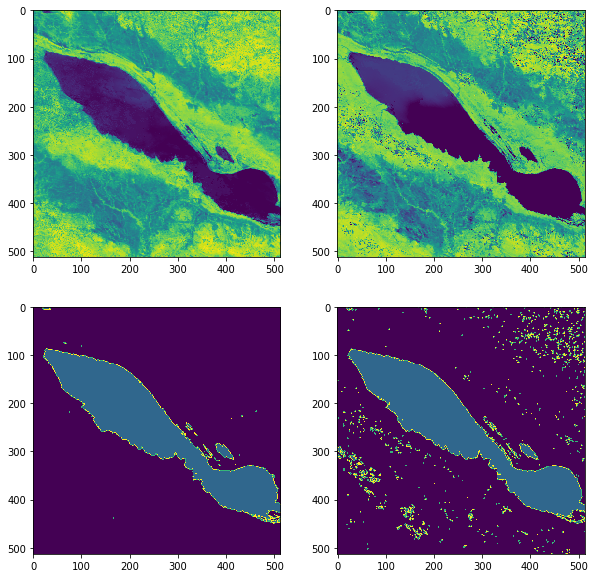

In [23]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))
axes[0][0].imshow(inputs_1[0])
axes[0][1].imshow(target_1[0])
axes[1][0].imshow(input_pixel_weights_1[0])
axes[1][1].imshow(target_pixel_weights_1[0])

In [34]:
from shutil import make_archive

In [35]:
make_archive('data', 'zip', sequence_data_dir)

'/media/lamductan/EHDD/Test/ERCL/data.zip'